Sveučilište u Zagrebu  
Fakultet elektrotehnike i računarstva  
  
## Strojno učenje 1 2021/2022
http://www.fer.unizg.hr/predmet/struce1

------------------------------

### Logistička regresija

*Verzija: 1.0 
Zadnji put ažurirano: 1. 10. 2021.*

(c) 2015-2021 Jan Šnajder, Domagoj Alagić  

Rok za predaju: **7. studenog 2021. u 23:59h**

------------------------------

### Upute

Ova laboratorijska vježba sastoji se od četiri zadatka. U nastavku slijedite upute navedene u ćelijama s tekstom. Rješavanje vježbe svodi se na **dopunjavanje ove bilježnice**: umetanja ćelije ili više njih **ispod** teksta zadatka, pisanja odgovarajućeg kôda te evaluiranja ćelija. 

Osigurajte da u potpunosti **razumijete** kôd koji ste napisali. Kod predaje vježbe, morate biti u stanju na zahtjev asistenta (ili demonstratora) preinačiti i ponovno evaluirati Vaš kôd. Nadalje, morate razumjeti teorijske osnove onoga što radite, u okvirima onoga što smo obradili na predavanju. Ispod nekih zadataka možete naći i pitanja koja služe kao smjernice za bolje razumijevanje gradiva (**nemojte pisati** odgovore na pitanja u bilježnicu). Stoga se nemojte ograničiti samo na to da riješite zadatak, nego slobodno eksperimentirajte. To upravo i jest svrha ovih vježbi.

Vježbe trebate raditi **samostalno**. Možete se konzultirati s drugima o načelnom načinu rješavanja, ali u konačnici morate sami odraditi vježbu. U protivnome vježba nema smisla.

In [1]:
# Učitaj osnovne biblioteke...
import sklearn
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def plot_2d_clf_problem(X, y, h=None):
    '''
    Plots a two-dimensional labeled dataset (X,y) and, if function h(x) is given, 
    the decision surfaces.
    '''
    assert X.shape[1] == 2, "Dataset is not two-dimensional"
    if h!=None : 
        # Create a mesh to plot in
        r = 0.04  # mesh resolution
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, r),
                             np.arange(y_min, y_max, r))
        XX=np.c_[xx.ravel(), yy.ravel()]
        try:
            Z_test = h(XX)
            if Z_test.shape == ():
                # h returns a scalar when applied to a matrix; map explicitly
                Z = np.array(list(map(h,XX)))
            else :
                Z = Z_test
        except ValueError:
            # can't apply to a matrix; map explicitly
            Z = np.array(list(map(h,XX)))
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)

    # Plot the dataset
    plt.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.tab20b, marker='o', s=50);

### 1. Logistička regresija

Ovaj zadatak bavi se probabilističkim diskriminativnim modelom, **logističkom regresijom**, koja je, unatoč nazivu, klasifikacijski model.

Logistička regresija tipičan je predstavnik tzv. **poopćenih linearnih modela** koji su oblika: $h(\mathbf{x})=f(\mathbf{w}^\intercal\tilde{\mathbf{x}})$. Logistička funkcija za funkciju $f$ koristi tzv. **logističku** (sigmoidalnu) funkciju $\sigma (x) = \frac{1}{1 + \textit{exp}(-x)}$.

### (a)  

Definirajte logističku (sigmoidalnu) funkciju $\mathrm{sigm}(x)=\frac{1}{1+\exp(-\alpha x)}$ i prikažite je za $\alpha\in\{1,2,4\}$.

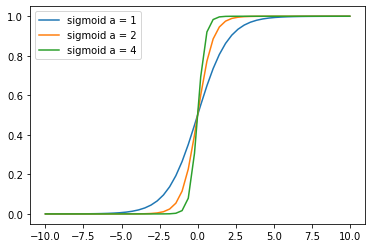

In [3]:
# Vaš kôd ovdje

def sigm(x, a):
    y = []
    for i in x:
        y.append(1/(1 + math.exp(-a*i)))
    return y

x = linspace(-10,10)
A = [1, 2, 4]

for a in A:
    plt.plot(list(x), sigm(x, a), label='sigmoid a = ' + str(a))

plt.legend(loc='upper left')
plt.show()

**Q**: Zašto je sigmoidalna funkcija prikladan izbor za aktivacijsku funkciju poopćenoga linearnog modela? 
</br>

**Q**: Kakav utjecaj ima faktor $\alpha$ na oblik sigmoide? Što to znači za model logističke regresije (tj. kako izlaz modela ovisi o normi vektora težina $\mathbf{w}$)?

### (b) 

Implementirajte funkciju 

> `lr_train(X, y, eta=0.01, max_iter=2000, alpha=0, epsilon=0.0001, trace=False)` 

za treniranje modela logističke regresije gradijentnim spustom (*batch* izvedba). Funkcija uzima označeni skup primjera za učenje (matrica primjera `X` i vektor oznaka `y`) te vraća $(n+1)$-dimenzijski vektor težina tipa `ndarray`. Ako je `trace=True`, funkcija dodatno vraća listu (ili matricu) vektora težina $\mathbf{w}^0,\mathbf{w}^1,\dots,\mathbf{w}^k$ generiranih kroz sve iteracije optimizacije, od 0 do $k$. Optimizaciju treba provoditi dok se ne dosegne `max_iter` iteracija, ili kada razlika u pogrešci unakrsne entropije između dviju iteracija padne ispod vrijednosti `epsilon`. Parametar `alpha` predstavlja faktor L2-regularizacije.

Preporučamo definiranje pomoćne funkcije `lr_h(x,w)` koja daje predikciju za primjer `x` uz zadane težine `w`. Također, preporučamo i funkciju `cross_entropy_error(X,y,w)` koja izračunava pogrešku unakrsne entropije modela na označenom skupu `(X,y)` uz te iste težine.

**NB:** Obratite pozornost na to da je način kako su definirane oznake ($\{+1,-1\}$ ili $\{1,0\}$) kompatibilan s izračunom funkcije gubitka u optimizacijskome algoritmu.

In [4]:
from numpy import linalg
from sklearn.preprocessing import PolynomialFeatures

def lr_h(x,w):
    z = np.dot(w, x)
    return 1/(1 + math.exp(-z))
    
def cross_entropy_error(X,y,w):
    entropy = 0
    for i in range(0, len(X)):
        entropy = entropy + (-y[i]*np.log(lr_h(X[i], w.T) - (1 - y[i])*np.log(1 - lr_h(X[i], w.T))))
    return entropy #/len(X)

                             
def lr_train(X, y, eta=0.01, max_iter=2000, alpha=0, epsilon=0.0001, trace=False):
    
    p = PolynomialFeatures(1, interaction_only=False)
    design_matrix = p.fit_transform(X)
    
    w0 = np.zeros(1)
    w = np.zeros(len(X[0]))
    weights = np.concatenate([w0, w])
    all_weights = np.array(weights)
    
    entro_before = None
    entro_current = 0
    entro = []
    
    for i in range(0, max_iter):
        if entro_before is not None and abs(entro_current - entro_before) <= epsilon:
                break
        else:
            
            delta_w0 = np.zeros(1)
            delta_w = np.zeros(len(X[0]))
            
            for j in range(0, len(X)):
                h = lr_h(design_matrix[j], weights.T)
                delta_w0 = delta_w0 - (h - y[j])
                delta_w = delta_w - (h - y[j]) * X[j]
            w0 = w0 + eta*delta_w0
            w = w*(1-alpha*eta) + eta*delta_w
            weights = np.concatenate([w0, w])
            all_weights = np.vstack([all_weights, weights])
            entro_before = entro_current
            entro_current = cross_entropy_error(design_matrix, y, weights)
            entro.append(entro_current)
    
    if trace:
        return weights, all_weights
    return weights

### (c)

Koristeći funkciju `lr_train`, trenirajte model logističke regresije na skupu `seven`, prikažite dobivenu granicu između klasa te  izračunajte pogrešku unakrsne entropije. 

**NB:** Pripazite da modelu date dovoljan broj iteracija.

In [5]:
seven_X = np.array([[2,1], [2,3], [1,2], [3,2], [5,2], [5,4], [6,3]])
seven_y = np.array([1, 1, 1, 1, 0, 0, 0])

Pogreška unakrsne entropije iznosi: 0.4639312289590283


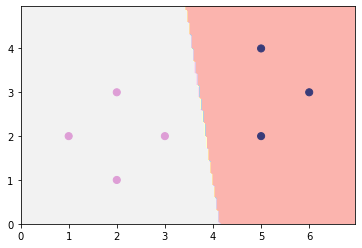

In [6]:
# Vaš kôd ovdje

def lr_h2(x,w):
    p = PolynomialFeatures(1, interaction_only=False)
    x = p.fit_transform(x)
    y = []
    for i in range(0, len(x)):
        y.append(round((1/(1 + math.exp(-np.dot(w, x[i].T))))))
    return np.array(y)

w = lr_train(seven_X, seven_y, alpha= 0.5)
p = PolynomialFeatures(1, interaction_only=False)
design_matrix = p.fit_transform(seven_X)
plot_2d_clf_problem(seven_X, seven_y, lambda seven_X : lr_h2(seven_X, w))
print('Pogreška unakrsne entropije iznosi: ' + str(cross_entropy_error(design_matrix, seven_y, w)))

**Q:** Koji kriterij zaustavljanja je aktiviran?

**Q:** Zašto dobivena pogreška unakrsne entropije nije jednaka nuli?

**Q:** Kako biste utvrdili da je optimizacijski postupak doista pronašao hipotezu koja minimizira pogrešku učenja? O čemu to ovisi?

**Q:** Na koji način biste preinačili kôd ako biste htjeli da se optimizacija izvodi stohastičkim gradijentnim spustom (*online learning*)?

### (d)

Prikažite na jednom grafikonu pogrešku unakrsne entropije (očekivanje logističkog gubitka) i pogrešku klasifikacije (očekivanje gubitka 0-1) na skupu `seven` kroz iteracije optimizacijskog postupka. Koristite trag težina funkcije `lr_train` iz zadatka (b) (opcija `trace=True`). Na drugom grafikonu prikažite pogrešku unakrsne entropije kao funkciju broja iteracija za različite stope učenja, $\eta\in\{0.005,0.01,0.05,0.1\}$.

In [7]:
from sklearn.metrics import zero_one_loss

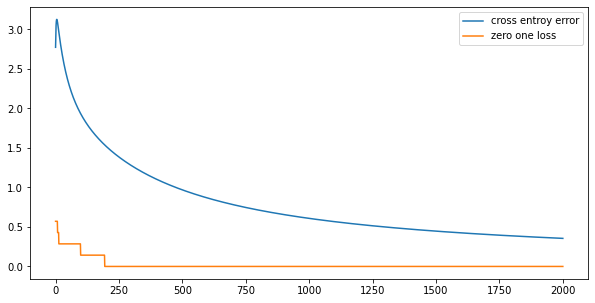

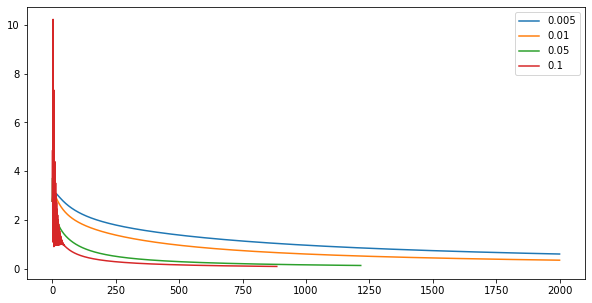

In [8]:
# Vaš kôd ovdje

plt.rcParams['figure.figsize']=(10,5)
w, all_weights = lr_train(seven_X, seven_y, trace = True)
p = PolynomialFeatures(1, interaction_only=False)
design_m = p.fit_transform(seven_X)
error = []
zer = []


for w in all_weights:
    error.append(cross_entropy_error(design_m, seven_y, w))
    zer.append(zero_one_loss(seven_y, lr_h2(seven_X, w)))


plt.plot(list(range(0, len(all_weights))), error, label = 'cross entroy error')
plt.plot(list(range(0, len(all_weights))), zer, label = 'zero one loss')
plt.legend(loc='upper right');
plt.show()


for e in [0.005,0.01,0.05,0.1]:
    error = []
    w, all_weights = lr_train(seven_X, seven_y, eta=e, trace = True)  
    for w in all_weights:
        error.append(cross_entropy_error(design_m, seven_y, w))
    plt.plot(list(range(0, len(all_weights))), error, label = str(e))

plt.legend(loc='upper right');
plt.show()


**Q:** Zašto je pogreška unakrsne entropije veća od pogreške klasifikacije? Je li to uvijek slučaj kod logističke regresije i zašto?

**Q:** Koju stopu učenja $\eta$ biste odabrali i zašto?

### (e)

Upoznajte se s klasom [`linear_model.LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) koja implementira logističku regresiju. Usporedite rezultat modela na skupu `seven` s rezultatom koji dobivate pomoću vlastite implementacije algoritma.

**NB:** Kako ugrađena implementacija koristi naprednije verzije optimizacije funkcije, vrlo je vjerojatno da Vam se rješenja neće poklapati, ali generalne performanse modela bi trebale. Ponovno, pripazite na broj iteracija i snagu regularizacije.

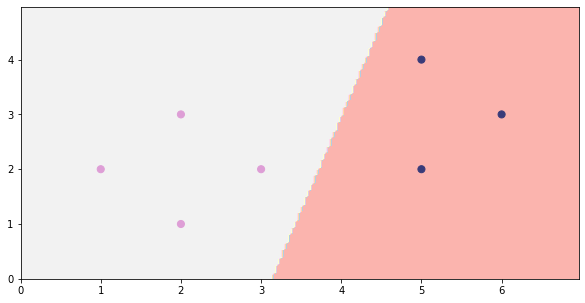

In [9]:
from sklearn.linear_model import LogisticRegression

# Vaš kôd ovdje

clf = LogisticRegression(penalty='none').fit(seven_X, seven_y)
clf.predict(seven_X)
plot_2d_clf_problem(seven_X, seven_y, clf.predict)

### 2. Analiza logističke regresije

### (a)

Koristeći ugrađenu implementaciju logističke regresije, provjerite kako se logistička regresija nosi s vrijednostima koje odskaču. Iskoristite skup `outlier`. Prikažite granicu između klasa.

In [10]:
outlier_X = np.append(seven_X, [[12,8]], axis=0)
outlier_y = np.append(seven_y, 0)

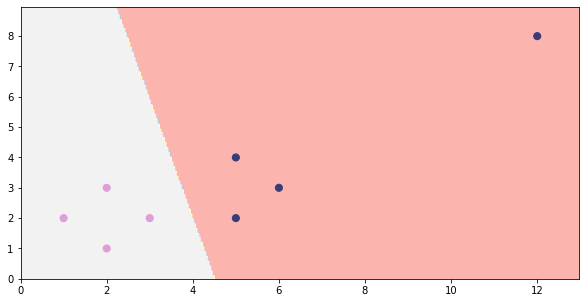

In [11]:
# Vaš kôd ovdje

clf = LogisticRegression(random_state=0).fit(outlier_X, outlier_y)
# print(accuracy_score(outlier_y, clf.predict(outlier_X)))
plot_2d_clf_problem(outlier_X, outlier_y, clf.predict)

**Q:** Zašto se rezultat razlikuje od onog koji je dobio model klasifikacije linearnom regresijom iz prvog zadatka?

### (b)

Trenirajte model logističke regresije na skupu `seven` te na dva odvojena grafikona prikažite, kroz iteracije optimizacijskoga algoritma, (1) izlaz modela $h(\mathbf{x})$ za svih sedam primjera te (2) vrijednosti težina $w_0$, $w_1$, $w_2$.

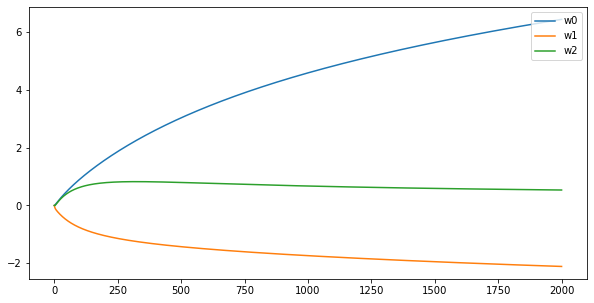

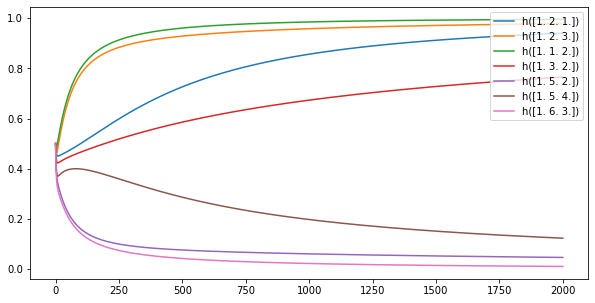

In [12]:
# Vaš kôd ovdje

w, all_weights = lr_train(seven_X, seven_y, trace = True)
w0 = []
w1 = []
w2 = []

p = PolynomialFeatures(1, interaction_only=False)
matrix = p.fit_transform(seven_X)

for i in range(0, len(all_weights)):
    w0.append(all_weights[i][0])
    w1.append(all_weights[i][1])
    w2.append(all_weights[i][2])
    
plt.plot(list(range(0, len(all_weights))), w0, label = 'w0')
plt.plot(list(range(0, len(all_weights))), w1, label = 'w1')
plt.plot(list(range(0, len(all_weights))), w2, label = 'w2')
plt.legend(loc='upper right');
plt.show()

for x in matrix:
    l = []
    for i in all_weights:
        l.append(lr_h(x, i.T))
    plt.plot(list(range(0, len(all_weights))), l, label ='h(' + str(x) + ')')

plt.legend(loc='upper right');
plt.show()

### (c)

Ponovite eksperiment iz podzadatka (b) koristeći linearno neodvojiv skup podataka `unsep`.

In [13]:
unsep_X = np.append(seven_X, [[2,2]], axis=0)
unsep_y = np.append(seven_y, 0)

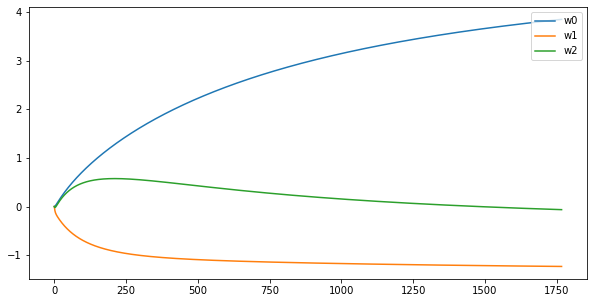

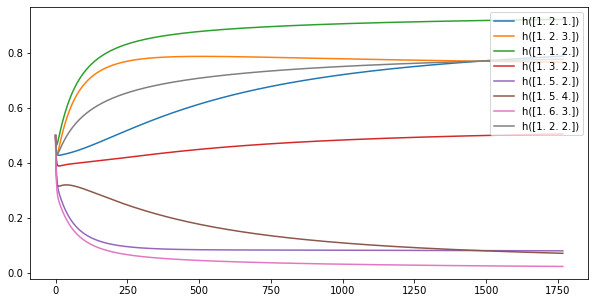

In [14]:
# Vaš kôd ovdje

w, all_weights = lr_train(unsep_X, unsep_y, trace = True)
w0 = []
w1 = []
w2 = []

p = PolynomialFeatures(1, interaction_only=False)
matrix = p.fit_transform(unsep_X)

for i in range(0, len(all_weights)):
    w0.append(all_weights[i][0])
    w1.append(all_weights[i][1])
    w2.append(all_weights[i][2])
    
plt.plot(list(range(0, len(all_weights))), w0, label = 'w0')
plt.plot(list(range(0, len(all_weights))), w1, label = 'w1')
plt.plot(list(range(0, len(all_weights))), w2, label = 'w2')
plt.legend(loc='upper right');
plt.show()

for x in matrix:
    l = []
    for i in all_weights:
        l.append(lr_h(x, i.T))
    plt.plot(list(range(0, len(all_weights))), l, label ='h(' + str(x) + ')')

plt.legend(loc='upper right');
plt.show()

**Q:** Usporedite grafikone za slučaj linearno odvojivih i linearno neodvojivih primjera te komentirajte razliku.

### 3. Regularizirana logistička regresija

Trenirajte model logističke regresije na skupu `seven` s različitim faktorima L2-regularizacije, $\alpha\in\{0,1,10,100\}$. Prikažite na dva odvojena grafikona (1) pogrešku unakrsne entropije te (2) L2-normu vektora $\mathbf{w}$ kroz iteracije optimizacijskog algoritma.

In [15]:
from numpy.linalg import norm

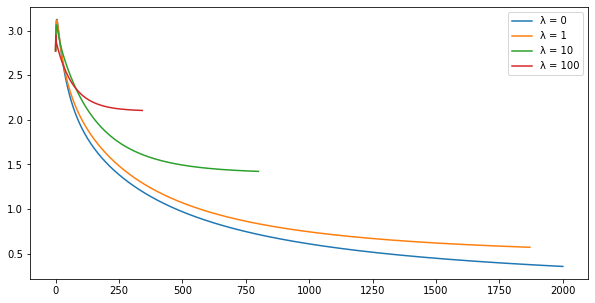

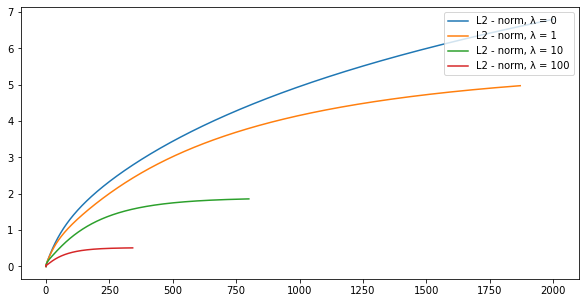

In [16]:
# Vaš kôd ovdje

for a in [0,1,10,100]:
    error = []
    w, all_weights = lr_train(seven_X, seven_y, alpha=a, trace = True)  
    for w in all_weights:
        error.append(cross_entropy_error(design_m, seven_y, w))
    plt.plot(list(range(0, len(all_weights))), error, label = 'λ = ' + str(a))

plt.legend(loc='upper right');
plt.show()    

for a in [0,1,10,100]:
    norm = []
    w, all_weights = lr_train(seven_X, seven_y, alpha=a, trace = True)  
    for w in all_weights:
        norm.append(np.linalg.norm(w))
    plt.plot(list(range(0, len(all_weights))), norm, label = 'L2 - norm, λ = ' + str(a))

plt.legend(loc='upper right');
plt.show()

**Q:** Jesu li izgledi krivulja očekivani i zašto?

**Q:** Koju biste vrijednost za $\alpha$ odabrali i zašto?

### 4. Logistička regresija s funkcijom preslikavanja

Proučite funkciju [`datasets.make_classification`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html). Generirajte i prikažite dvoklasan skup podataka s ukupno $N=100$ dvodimenzijskih ($n=2)$ primjera, i to sa dvije grupe po klasi (`n_clusters_per_class=2`). Malo je izgledno da će tako generiran skup biti linearno odvojiv, međutim to nije problem jer primjere možemo preslikati u višedimenzijski prostor značajki pomoću klase [`preprocessing.PolynomialFeatures`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html), kao što smo to učinili kod linearne regresije u prvoj laboratorijskoj vježbi. Trenirajte model logističke regresije koristeći za preslikavanje u prostor značajki polinomijalnu funkciju stupnja $d=2$ i stupnja $d=3$. Prikažite dobivene granice između klasa. Možete koristiti svoju implementaciju, ali se radi brzine preporuča koristiti `linear_model.LogisticRegression`. Regularizacijski faktor odaberite po želji.

**NB:** Kao i ranije, za prikaz granice između klasa koristite funkciju `plot_2d_clf_problem`. Funkciji kao argumente predajte izvorni skup podataka, a preslikavanje u prostor značajki napravite unutar poziva funkcije `h` koja čini predikciju, na sljedeći način:

In [17]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=2)
#plot_2d_clf_problem(X, y, lambda x : model.predict(poly.transform(x))

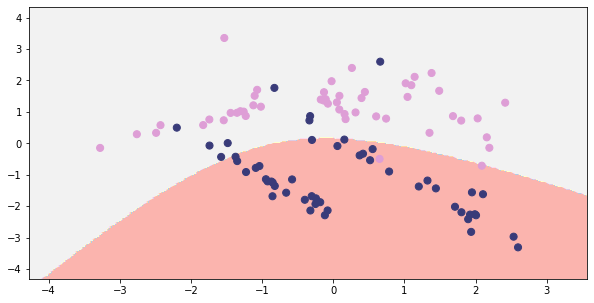

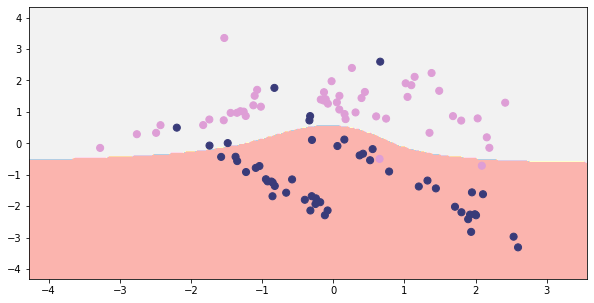

In [18]:
from sklearn.datasets import make_classification

# Vaš kôd ovdje

poly_2 = PolynomialFeatures(2, interaction_only=False)
design_matrix_2 = poly_2.fit_transform(X)

poly_3 = PolynomialFeatures(3, interaction_only=False)
design_matrix_3 = poly_3.fit_transform(X)

model = LogisticRegression(C=0.01).fit(design_matrix_2, y)
plot_2d_clf_problem(X, y, lambda x : model.predict(poly_2.transform(x)))
plt.show()

model = LogisticRegression(C=0.01).fit(design_matrix_3, y)
plot_2d_clf_problem(X, y, lambda x : model.predict(poly_3.transform(x)))
plt.show()

**Q:** Koji biste stupanj polinoma upotrijebili i zašto? Je li taj odabir povezan s odabirom regularizacijskog faktora $\alpha$? Zašto?